In [1]:
import numpy as np
import pandas as pd

In [2]:
points = pd.read_csv('data/TSP.csv', header=None, usecols=[1, 2], names=["x", "y"])
points.head()

,x,y
0,565,575
1,25,185
2,345,750
3,945,685
4,845,655


# Random path

In [3]:
def get_random_path():
    shuffled = points.reindex(np.random.permutation(points.index))
    return shuffled['x'].as_matrix(), shuffled['y'].as_matrix()

def manhattan_length(xs, ys):
    result = 0
    pts = zip(xs, ys)
    prev = next(pts)
    for pt in pts:
        result += np.abs(pt[0] - prev[0]) + np.abs(pt[1] - prev[1])
        prev = pt
    return result

def plotable_points(xs, ys):
    pts = zip(xs, ys)
    prev = next(pts)
    x_new = [prev[0]]
    y_new = [prev[1]]
    for pt in pts:
        if pt[0] != prev[0] and pt[1] != prev[1]:
            x_new.append(prev[0])
            y_new.append(pt[1])
        x_new.append(pt[0])
        y_new.append(pt[1])
        prev = pt
    return x_new, y_new

def plot_path(xs, ys):
    import matplotlib.pyplot as plt
    pxs, pys = plotable_points(xs, ys)
    fig = plt.figure(figsize=(20,12))
    plt.plot(pxs, pys, 'k')
    plt.plot(xs, ys, 'ro')
    plt.plot([xs[0]], [ys[0]], 'r^', markersize=15)
    plt.plot([xs[-1]], [ys[-1]], 'gs', markersize=15)

    plt.show()
    

In [4]:
X,Y = get_random_path()

Path length = 41550


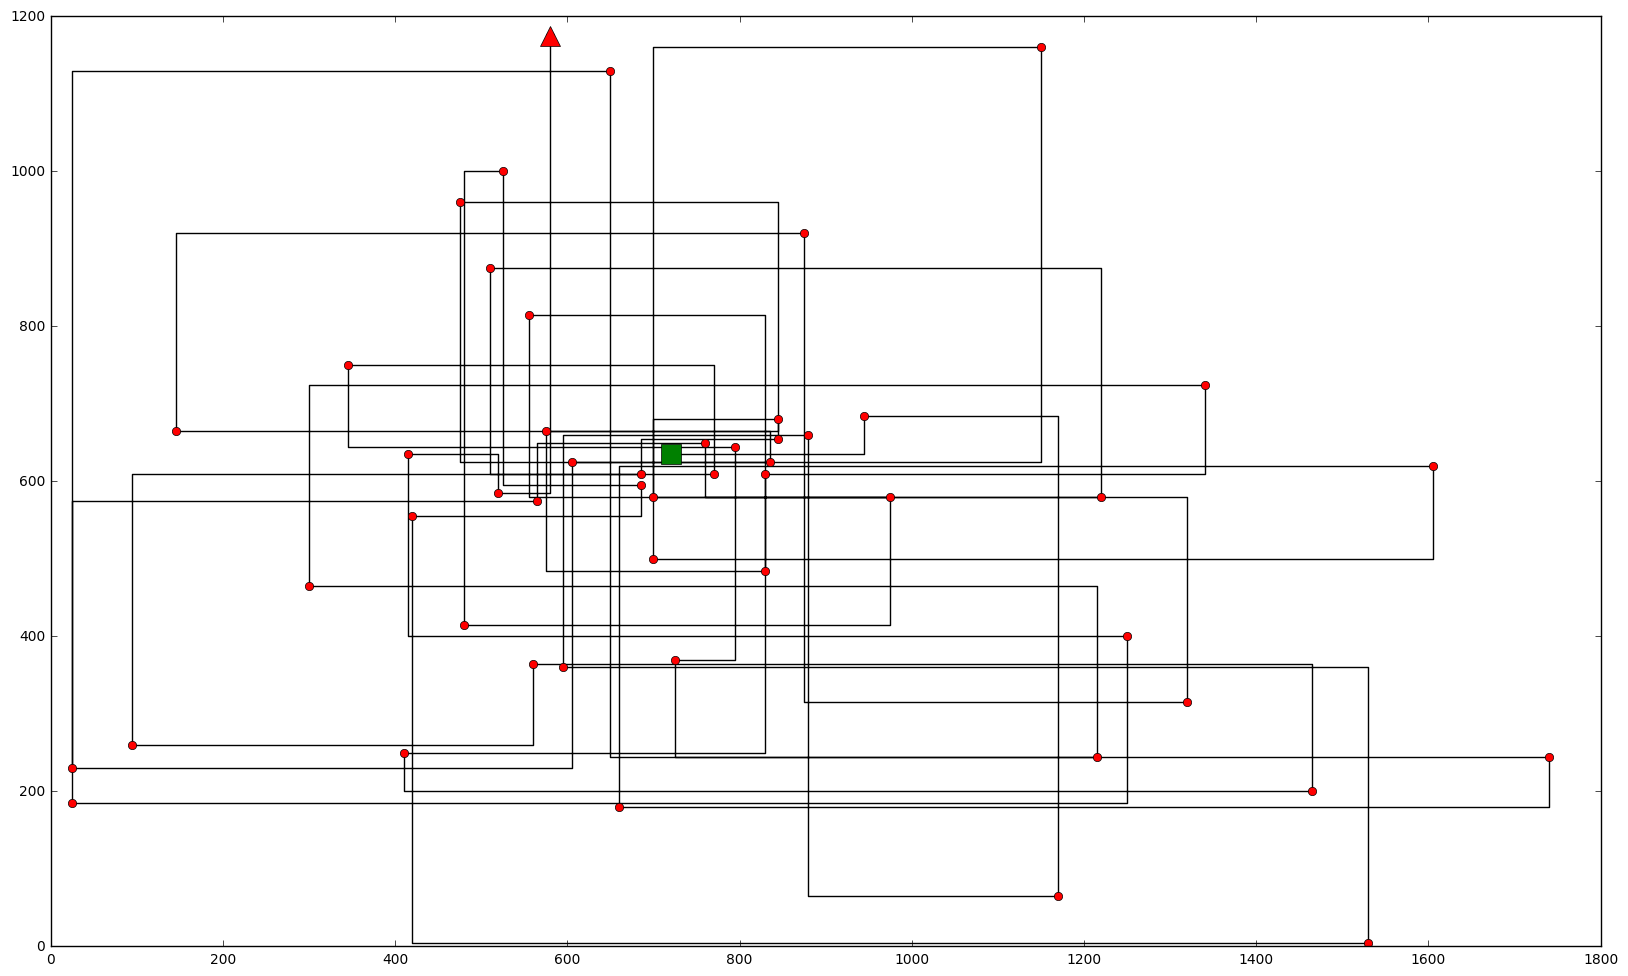

In [5]:
print("Path length = {}".format(manhattan_length(X, Y)))
plot_path(X, Y)

# Hill climbing

In [6]:
def perfrom_hillclimbing(stop=1000):
    from tqdm import tqdm
    X, Y = get_random_path()
    result = manhattan_length(X, Y)
    n = len(X)
    assert(n == len(Y))
    def swap(i, j):
        X[i], X[j] = X[j], X[i]
        Y[i], Y[j] = Y[j], Y[i]
    def try_increase(cur_min):
        for i in range(len(X)):
            for j in range(len(X)):
                swap(i, j)
                dist = manhattan_length(X, Y) # path is not so big, so whatever
                if dist < cur_min:
                    return True, dist
                else:
                    swap(i, j)
        return False, cur_min
    for _ in tqdm(range(stop)):
        is_better, result = try_increase(result)
        if not is_better:
            break
    return X, Y, result
        

In [7]:
xs, ys, manhattan_dist = perfrom_hillclimbing(1000)

 18%|█▊        | 179/1000 [00:07<02:27,  5.56it/s]


Path len = 12650


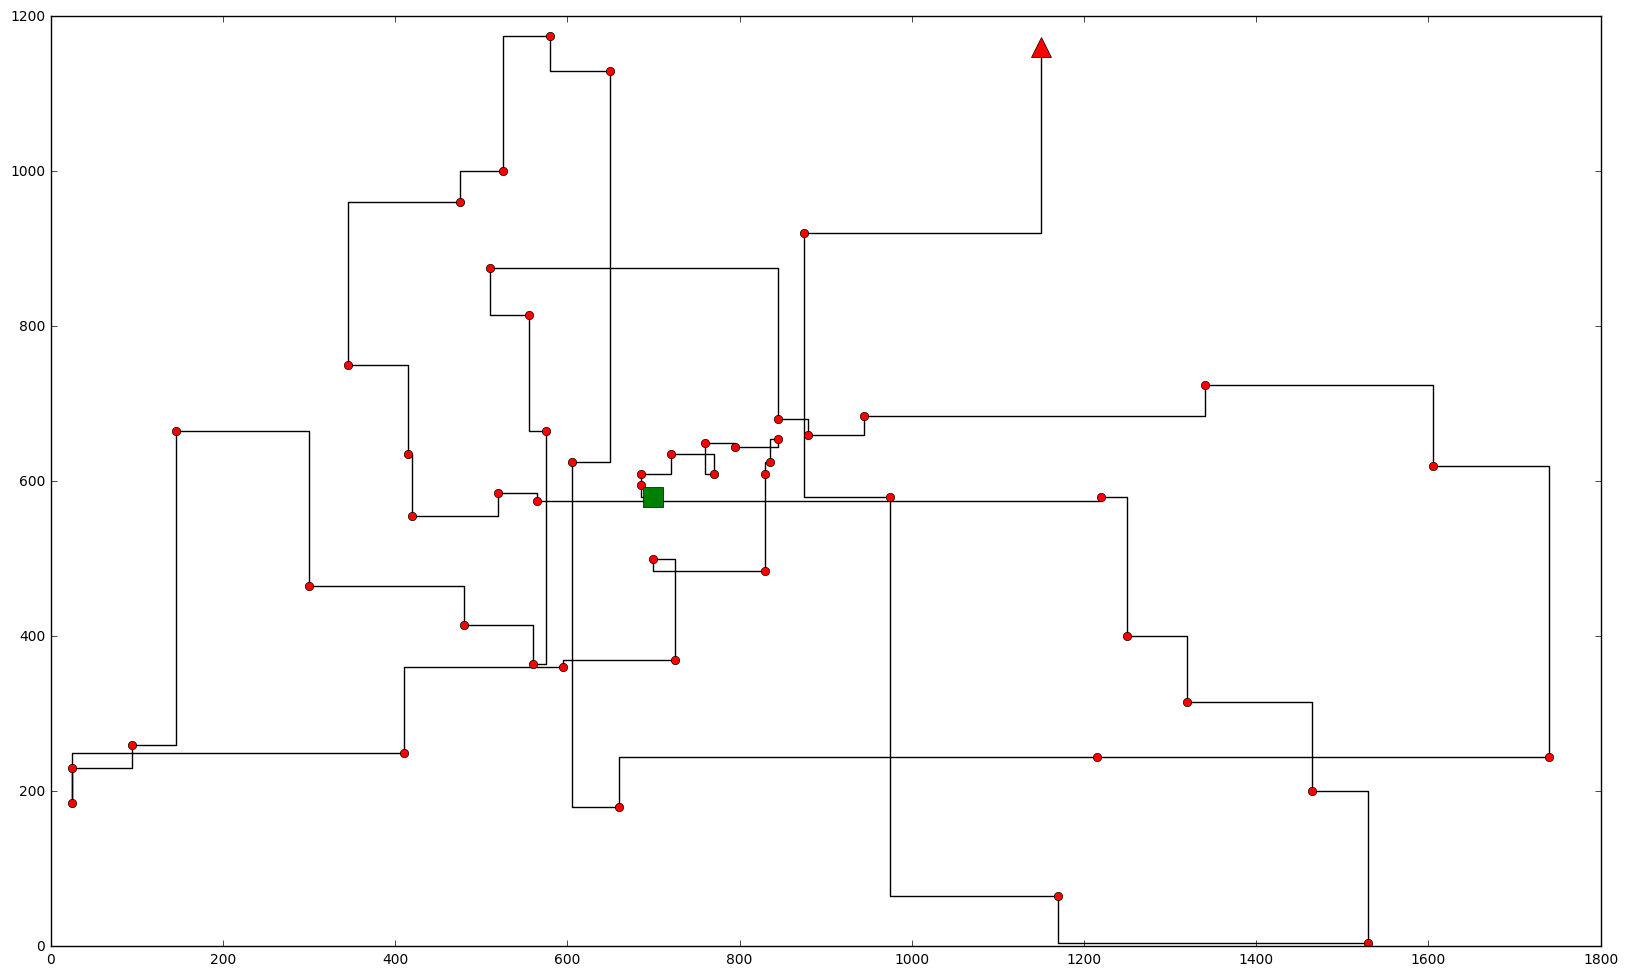

In [8]:
print("Path len = {}".format(manhattan_dist))
plot_path(xs, ys)

# Annealing

In [140]:
def do_annealing(X, Y, T):
    def swap(i, j):
        X[i], X[j] = X[j], X[i]
        Y[i], Y[j] = Y[j], Y[i]
    dist = manhattan_length(X, Y)
    while T > 1:
        all_dists = []
        for i in range(len(X)):
            for j in range(len(Y)):
                if i == j:
                    continue
                swap(i, j)
                all_dists.append(manhattan_length(X, Y))
                swap(i, j)
        all_dists = np.array(all_dists)
        tmp = np.exp(-(all_dists - dist) / T)
        summ = tmp.sum()
        probs = [tmp[i] / summ for i in range(len(tmp))]
        swaps = [(i, j) for i in range(len(X)) for j in range(len(X)) if i != j]
        swaps.insert(0, [])
        n_swaps = np.array(swaps, object)
        n_swaps = np.delete(n_swaps, 0)
        i, j = np.random.choice(n_swaps, p=probs)
        swap(i, j)
        new_dist = manhattan_length(X, Y)
        if new_dist > dist:
            pr = np.exp(-(new_dist - dist) / T)
            if np.random.binomial(n=1, p=pr) == 0:
                swap(i, j)
            else:
                dist = new_dist
        else:
            dist = new_dist
        T *= 0.99
    return X, Y, dist

In [141]:
X, Y = get_random_path()
ansX, ansY, score = do_annealing(X, Y, T=100)

11305


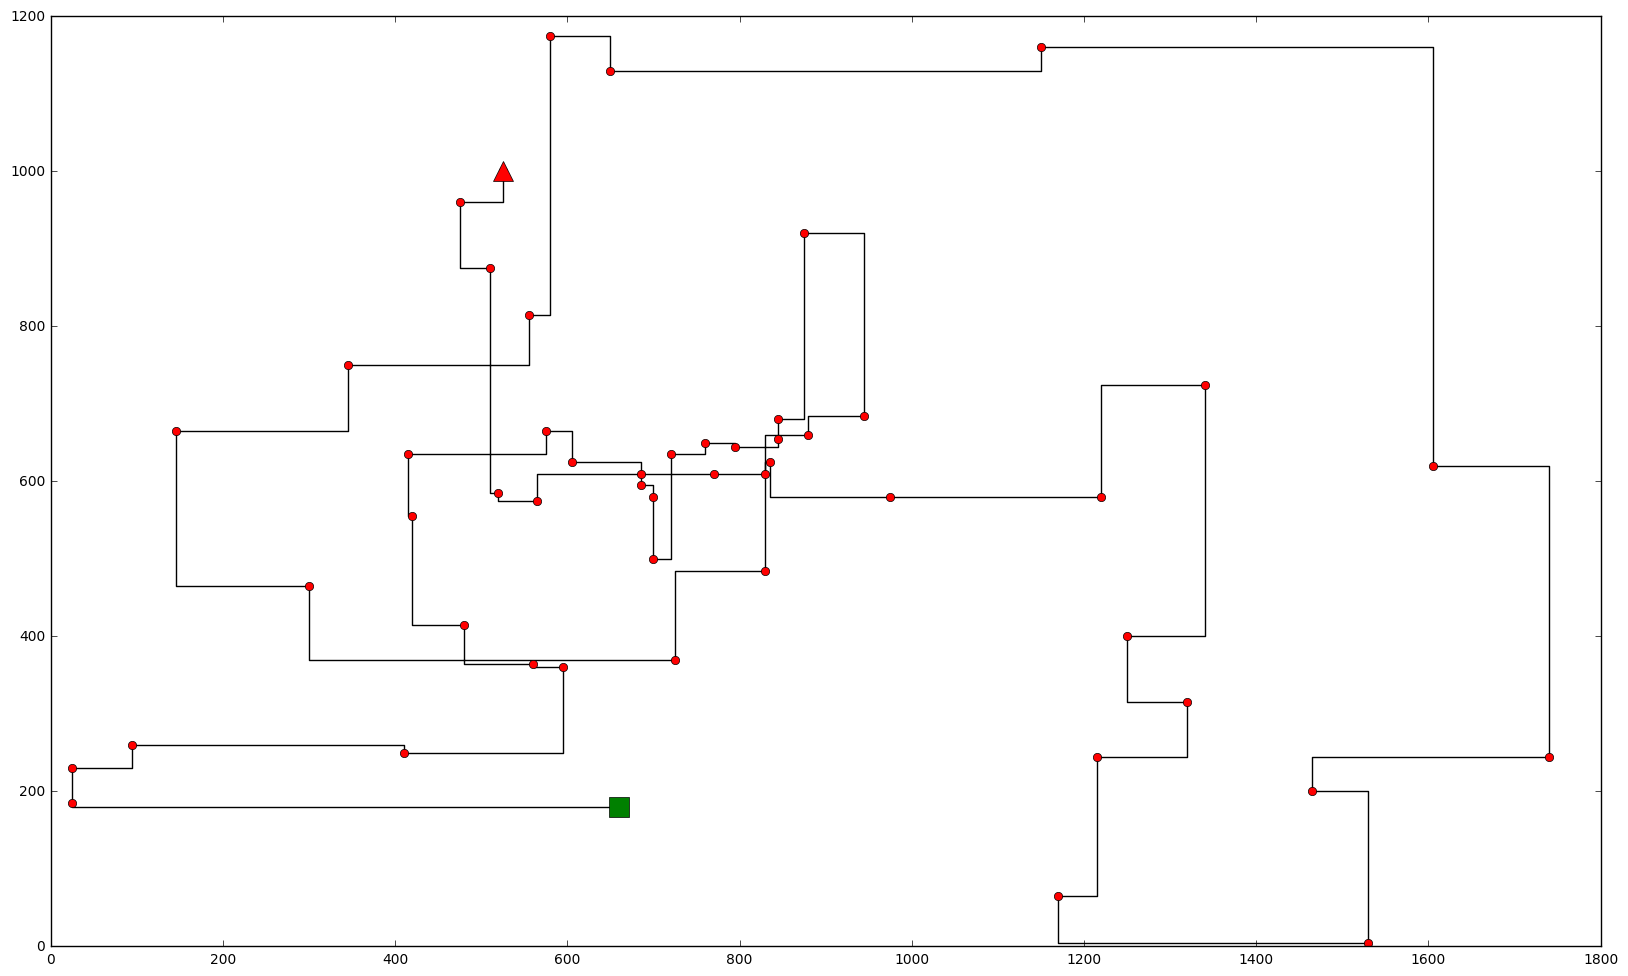

In [142]:
print(score)
plot_path(ansX, ansY)